# MNIST를 통해서 DNN작업하기


1. 데이터 로딩하기.

In [4]:
%matplotlib inline

import torch
from torchvision import datasets, transforms
import torch.nn as nn

#batch_size = 128
batch_size = 1024
train_dataset = datasets.MNIST('./data', train=True, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))
test_dataset = datasets.MNIST('./data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                             ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


50000 10000 10000


2. 기존 데이터를 추정해보자.

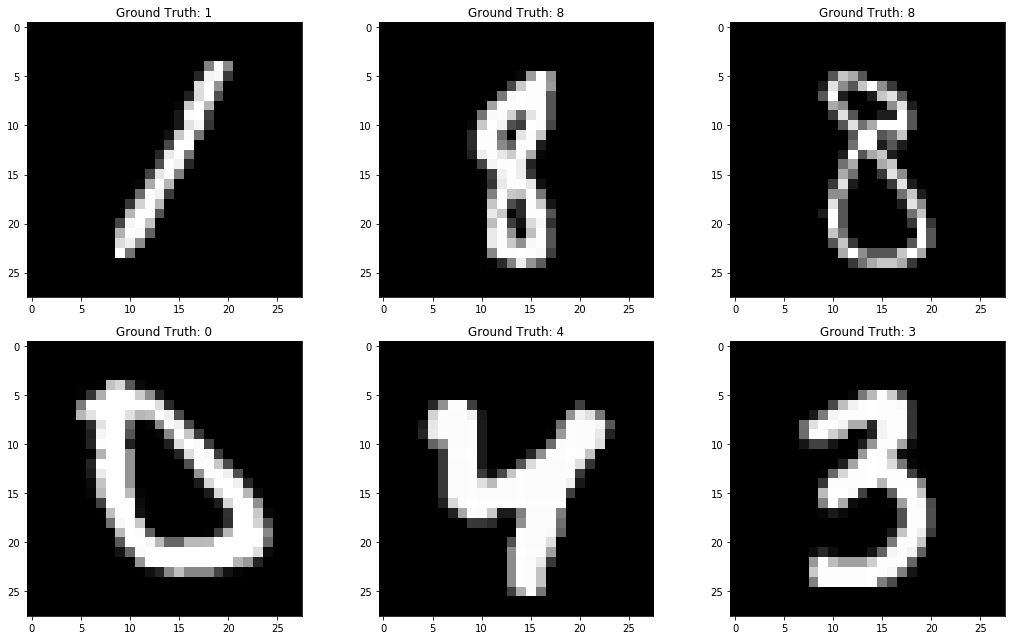

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot( 2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

3. Model 설정하기

In [21]:
class LinearModel(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_list) :
        super(LinearModel, self).__init__()
        if len(hidden_list) < 1:
            raise ValueError("hidden_lists must be over 1")
            
        input_layer = nn.Linear(in_dim, hidden_list[0])
        self.output_layer = nn.Linear(hidden_list[-1], out_dim)        
            
        arrHids = []    
        for ind in range( len(hidden_list) -1 ):            
            linear = nn.Linear(hidden_list[ind] , hidden_list[ind + 1])
            arrHids.append( linear )            
        arrLasts = [input_layer] + arrHids             
        self.moduleList = nn.ModuleList( arrLasts )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        for layer in self.moduleList:
            x = self.relu( layer(x) )
        x = self.output_layer(x)            
        return x
    

In [23]:
mymodel = LinearModel(784, 10, [ 30, 40, 50])
print("mymodel", mymodel)

mymodel LinearModel(
  (output_layer): Linear(in_features=50, out_features=10, bias=True)
  (moduleList): ModuleList(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=50, bias=True)
  )
  (relu): ReLU()
)


In [7]:
cls_loss  = nn.CrossEntropyLoss()

4. Train & Test 진행하기.

In [30]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel(784, 10, [50, 50, 50] )
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 10
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    optimizer.zero_grad() 
    
    for input_X, true_y in train_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    optimizer.zero_grad()
    
    for input_X, true_y in val_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        val_loss += loss.detach().numpy()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    optimizer.zero_grad()

    for input_X, true_y in test_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
        correct += pred_y.eq(true_y).sum()

    acc = correct.numpy() / len(test_loader.dataset)
    list_acc.append(acc)
    list_acc_epoch.append(i)
    
    print('Epoch: {0}, Train Loss: {1:2.4f}, Val Loss: {2:2.4f}, Test Acc: {3:2.4f}%'.format(i, train_loss, val_loss, acc*100))

Number of 44860 parameters
Epoch: 0, Train Loss: 2.2299, Val Loss: 1.9559, Test Acc: 38.1400%
Epoch: 1, Train Loss: 1.3499, Val Loss: 0.7200, Test Acc: 81.1000%
Epoch: 2, Train Loss: 0.5441, Val Loss: 0.4726, Test Acc: 86.6700%
Epoch: 3, Train Loss: 0.4013, Val Loss: 0.3983, Test Acc: 88.5900%
Epoch: 4, Train Loss: 0.3303, Val Loss: 0.3291, Test Acc: 90.8500%
Epoch: 5, Train Loss: 0.2841, Val Loss: 0.2957, Test Acc: 91.6800%
Epoch: 6, Train Loss: 0.2538, Val Loss: 0.2603, Test Acc: 92.6700%
Epoch: 7, Train Loss: 0.2275, Val Loss: 0.2382, Test Acc: 93.2300%
Epoch: 8, Train Loss: 0.2038, Val Loss: 0.2122, Test Acc: 94.2700%
Epoch: 9, Train Loss: 0.1871, Val Loss: 0.2078, Test Acc: 94.1500%


5. Report Experiment

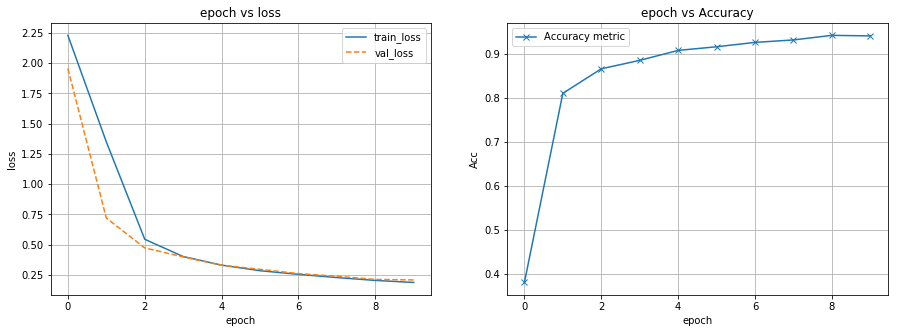

In [31]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()